In [2]:
import pandas as pd # standard
import numpy as np # standard
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score # for accuracy calculation
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import thermogram_utilities

import warnings
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_excel("/Users/avery/OneDrive/Documents/GitHub/Clinical_TLB_2023-2024/lung_cancer_tlb.xlsx")
df['CancerType'] = np.where(df['CancerType'].isna(), 'Control', df['CancerType'])

In [8]:
df['CancerType'].value_counts()

CancerType
Adenocarcinoma    72
Control           51
Squamous          46
SCLC              16
NOS                8
Large cell         6
Name: count, dtype: int64

In [3]:
df = pd.read_excel("/Users/avery/OneDrive/Documents/GitHub/Clinical_TLB_2023-2024/lung_cancer_tlb.xlsx")

# replace NA with control
df['CancerType'] = np.where(df['CancerType'].isna(), 'Control', df['CancerType'])

# get location of cut off values
lower_column_index = df.columns.get_loc("T51")
upper_column_index = df.columns.get_loc("T83.1")
label_column_index = df.columns.get_loc("CancerType")

column_indices = np.arange(lower_column_index, upper_column_index)
column_indices = np.append(column_indices, 0)
column_indices = np.append(column_indices, 1)



column_indices = np.append(column_indices, label_column_index)

df = df.iloc[:, column_indices]

# keep only Control and Adenocarcinoma for analysis
df_tree = df[(df['CancerType'] == 'Control') | (df['CancerType'] == 'Adenocarcinoma')]
df_tree = df_tree.reset_index(drop=True)

In [4]:
performance_metrics = pd.DataFrame(columns=['Weighted Accuracy', 'AUC', 'n_estimators', "max_depth", "max_features"])

# set number of bootstraps
total_bootstraps = 100

# length of df
num_rows = df_tree.shape[0]

# create array of all indices in full data set
all_indices = np.arange(num_rows)

# columns to drop
drop_cols = ['sample_id', 'pub_id', 'CancerType']


# loop for specified iterations
for i in range(total_bootstraps):
    
    # randomly select indices to use as train set
    train_indices = np.random.choice(num_rows, num_rows, replace = True)

    # get the train set using the indices
    train_set = df_tree.iloc[train_indices, : ]

    # get indices not included in train_indices to use as test set
    test_indices = np.setdiff1d(all_indices, train_indices)

    # get test set using test indices
    test_set = df_tree.iloc[test_indices, :]

    for trees in [100, 250, 500, 1000]:
            
        for depth in [round(num_rows/2), None]:

            for features in ["sqrt", "log2", None]:


                # initialize random forest (default settings)
                clf = RandomForestClassifier(n_estimators=trees, max_depth=depth, max_features=features)

                # train forest
                clf = clf.fit(train_set.drop(drop_cols, axis = 1), train_set['CancerType'])

                # get probabilities
                test_probabilities = clf.predict_proba(test_set.drop(drop_cols, axis = 1))

                # test decision tree
                test_predictions = clf.predict(test_set.drop(drop_cols, axis = 1))

                # calculate weighted accuracy
                balanced_acc = balanced_accuracy_score(test_set['CancerType'], test_predictions)

                # calculate AUC
                auc = roc_auc_score(test_set['CancerType'] == 'Control', test_probabilities[:, 1])

                # append accuracy, auc to results df
                performance_metrics.loc[len(performance_metrics)] = [balanced_acc, auc, trees, depth, features]

    performance_metrics.to_excel('sensitivity_analysis_2.xlsx', index=False)

    print(i)



0


In [3]:
sensitivity_analysis_df = pd.read_excel("sensitivity_analysis_1.xlsx")
sensitivity_analysis_df["max_features"] = sensitivity_analysis_df['max_features'].fillna('None')
sensitivity_analysis_df["max_depth"] = sensitivity_analysis_df['max_depth'].fillna('None')
result = sensitivity_analysis_df.groupby(['n_estimators', 'max_depth', 'max_features']).mean()

In [5]:
boot_strap_number = np.repeat(np.arange(0, 1000), 24)
boot_strap_number = pd.Series(boot_strap_number)
result = pd.concat([boot_strap_number, sensitivity_analysis_df], axis=1)
result["max_features"] = result['max_features'].fillna('None')

result_1 = result.groupby(['n_estimators', 'max_depth', 'max_features']).mean()

We use sort_values() to sort the DataFrame by 'Value' in descending order.
We then use groupby('Group') to group the sorted DataFrame by the 'Group' column.
Finally, we use .head(1) to select the first row within each group, which corresponds to the row with the highest 'Value'.

In [ ]:
hyper_parameter_combinations = result.sort_values(by='Weighted Accuracy', ascending=False).groupby(0).head(1)

hyper_parameter_combinations

,0,Weighted Accuracy,AUC,n_estimators,max_depth,max_features
18495,770,0.829228,0.818555,250,123,sqrt
6888,287,0.815686,0.803922,50,62,sqrt
19377,807,0.800926,0.807870,100,123,sqrt
13340,555,0.798137,0.740683,500,62,None
20483,853,0.792735,0.727564,100,123,None
...,...,...,...,...,...,...
15727,655,0.476716,0.484069,100,62,log2
12723,530,0.453202,0.376847,50,123,sqrt
1178,49,0.452012,0.383127,50,62,None
17242,718,0.445701,0.418552,100,123,log2


<Axes: xlabel='n_estimators', ylabel='Weighted Accuracy'>

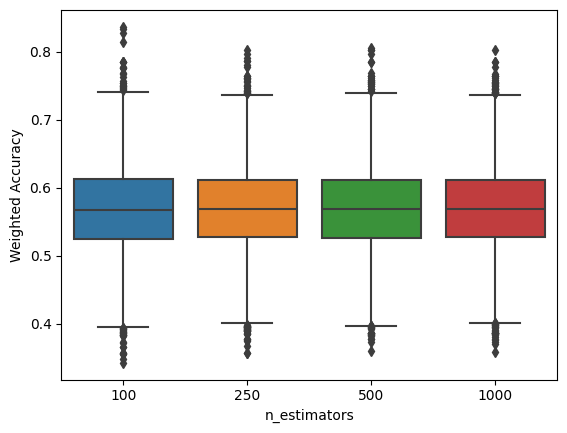

In [6]:
sns.boxplot(data=result, x='n_estimators', y='Weighted Accuracy')

<Axes: xlabel='max_depth', ylabel='Weighted Accuracy'>

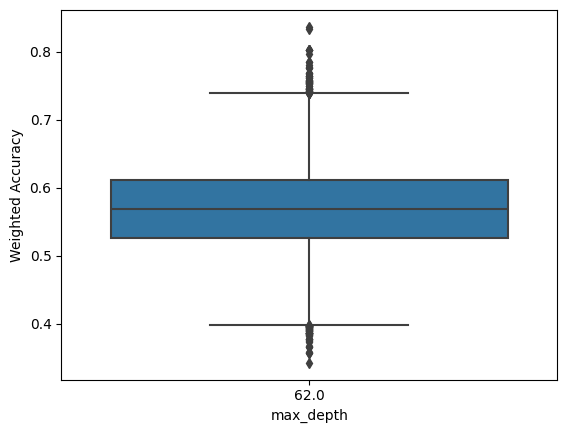

In [7]:
sns.boxplot(data=result, x='max_depth', y='Weighted Accuracy')


<Axes: xlabel='max_features', ylabel='Weighted Accuracy'>

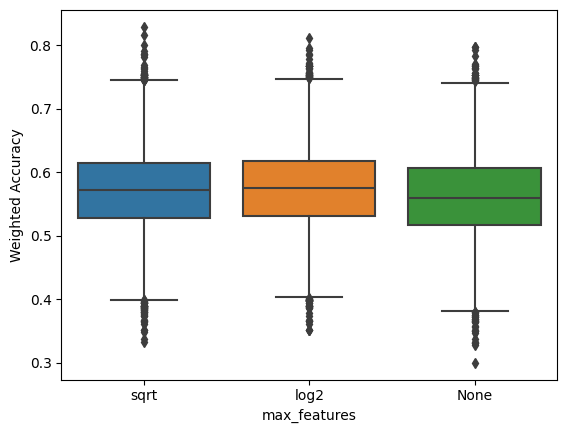

In [ ]:
sns.boxplot(data=result, x='max_features', y='Weighted Accuracy')


In [ ]:
hyper_parameter_combinations['n_estimators'].value_counts()

n_estimators
50     404
100    292
250    181
500    123
Name: count, dtype: int64